In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [58]:
#normaliza o dataset usando um pouco de data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#normaliza o dataset de test mas sem data augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
#dataset de treino com batch de tamanho 32 e de teste com tamanho 4
train_loader = DataLoader(dataset=dataset_train, shuffle=True,batch_size  = 32)
test_loader = DataLoader(dataset=dataset_test, shuffle=False,batch_size =4 )

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(len(train_loader))

torch.Size([32, 3, 32, 32])
cuda:0
1563


In [0]:

#definindo a Rede
class CNN(nn.Module):
  
  def __init__(self):
    super(CNN, self).__init__()

    self.conv_layer = nn.Sequential(
            
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
              
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),
            
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
            )

    self.fc_layer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(4096, 1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
        )


  def forward(self, x):  

    x = self.conv_layer(x)      
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x
  

#CONSTRUINDO O MODELO, SETANDO A LOSS E OPTIMIZER

In [0]:

# Constroi o modelo
net = CNN()
net = net.to(device)


#define a loss e o otimizador. SGD foi testado, mas não trouxe bons resultados
loss_cross = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#DEFININDO O TREINO

In [0]:
# TREINO
def train(epoch,train_acc,train_losses):
  print('\nEpoca: %d' % epoch)
  net.train()
  train_loss = []
  train_correct = 0
  train_total = 0
  train_accuracy = 0
  
  for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_cross(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    train_total += targets.size(0)
    train_correct += (predicted==targets).sum().item()
  train_accuracy = 100*train_correct/train_total
  train_losses.append(np.mean(train_loss))
  train_acc.append(train_accuracy)
  print(' train_loss : {:.4f} , train_ acc : {:.2f}%'\
            .format(np.mean(train_loss),train_accuracy))
      

#DEFININDO A VALIDAÇÃO 

In [0]:
#TESTE
def test(epoch,test_acc,test_losses):
  net.eval()
  test_correct = 0
  test_total = 0
  test_accuracy =0
  test_loss = []
  with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      loss = loss_cross(outputs, targets)
      test_loss.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      test_total += targets.size(0)
      test_correct += (predicted==targets).sum().item()
    test_accuracy = 100*test_correct/test_total
    test_acc.append(test_accuracy)
    test_losses.append(np.mean(test_loss))
    print(' test_loss : {:.4f} , test_ acc : {:.2f}%'\
            .format(np.mean(test_loss),test_accuracy))

#TREINADO DURANTE 50 EPOCAS


In [64]:


train_acc_net1 = []
train_losses_net1 = []
test_acc_net1 = []
test_losses_net1 = []

epochs =50


for epoch in range(epochs):
  train(epoch,train_acc = train_acc_net1,train_losses = train_losses_net1)
  test(epoch,test_acc = test_acc_net1,test_losses = test_losses_net1)


Epoca: 0
 train_loss : 1.5999 , train_ acc : 40.20%
 test_loss : 1.2606 , test_ acc : 54.65%

Epoca: 1
 train_loss : 1.1780 , train_ acc : 57.71%
 test_loss : 0.9790 , test_ acc : 65.57%

Epoca: 2
 train_loss : 0.9650 , train_ acc : 65.89%
 test_loss : 0.8245 , test_ acc : 71.40%

Epoca: 3
 train_loss : 0.8425 , train_ acc : 70.69%
 test_loss : 0.7271 , test_ acc : 74.59%

Epoca: 4
 train_loss : 0.7629 , train_ acc : 73.79%
 test_loss : 0.6739 , test_ acc : 77.16%

Epoca: 5
 train_loss : 0.7028 , train_ acc : 75.64%
 test_loss : 0.6291 , test_ acc : 78.66%

Epoca: 6
 train_loss : 0.6536 , train_ acc : 77.55%
 test_loss : 0.6265 , test_ acc : 79.13%

Epoca: 7
 train_loss : 0.6142 , train_ acc : 79.20%
 test_loss : 0.5419 , test_ acc : 81.79%

Epoca: 8
 train_loss : 0.5798 , train_ acc : 80.25%
 test_loss : 0.5895 , test_ acc : 80.24%

Epoca: 9
 train_loss : 0.5471 , train_ acc : 81.49%
 test_loss : 0.5415 , test_ acc : 82.12%

Epoca: 10
 train_loss : 0.5200 , train_ acc : 82.19%
 test_

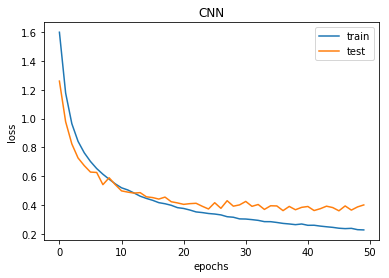

In [65]:
plt.title("CNN")
x = np.arange(0,epochs)
plt.plot(x,train_losses_net1,label = "train")
plt.plot(x,test_losses_net1,label = "test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#GRAFICO DO LOSS

#GRAFICO DA ACURÁCIA




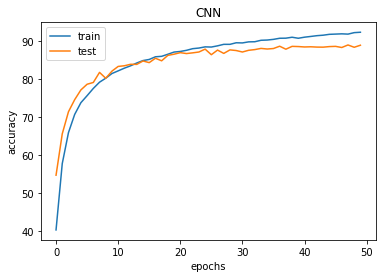

In [66]:
plt.title("CNN")
x = np.arange(0,epochs)
plt.plot(x,train_acc_net1,label = "train")
plt.plot(x,test_acc_net1,label = "test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()